In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [76]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [77]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [78]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [79]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [81]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


<AxesSubplot:xlabel='Date'>

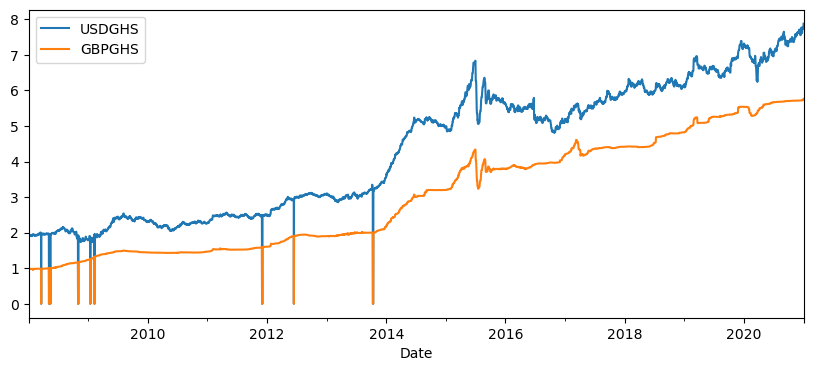

In [82]:
# Let's see a historical view of the closing price
df['USDGHS'].plot(legend=True, figsize=(10,4))
df['GBPGHS'].plot(legend=True, figsize=(10,4))

In [83]:
# Let's go ahead and plot out several moving averages
MA_day = [10,20,50,100]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df[column_name] = df['USDGHS'].rolling(window=ma).mean()


<AxesSubplot:xlabel='Date'>

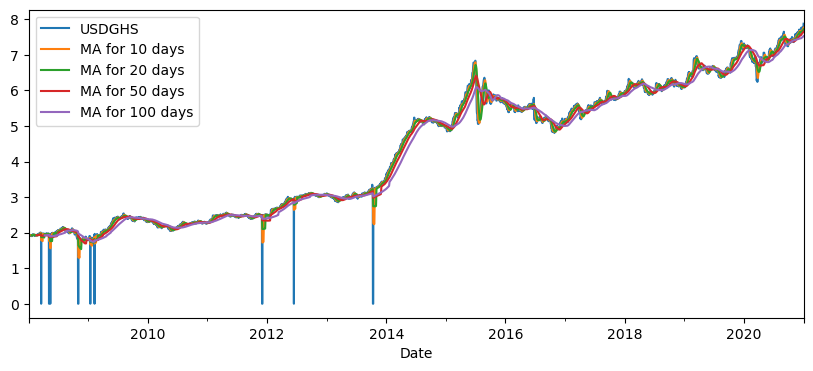

In [84]:
df[['USDGHS','MA for 10 days','MA for 20 days','MA for 50 days','MA for 100 days']].plot(subplots=False,figsize=(10,4))

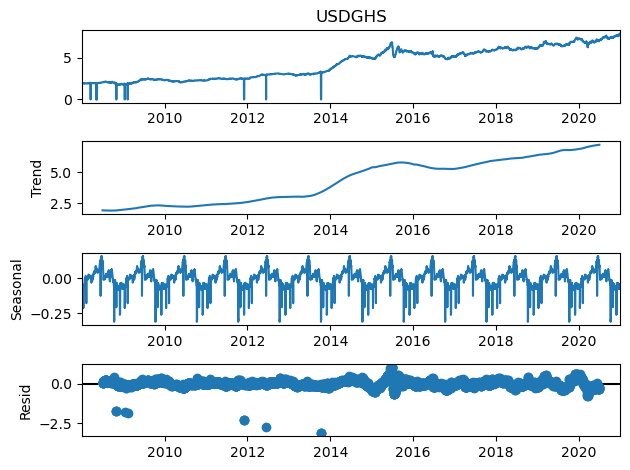

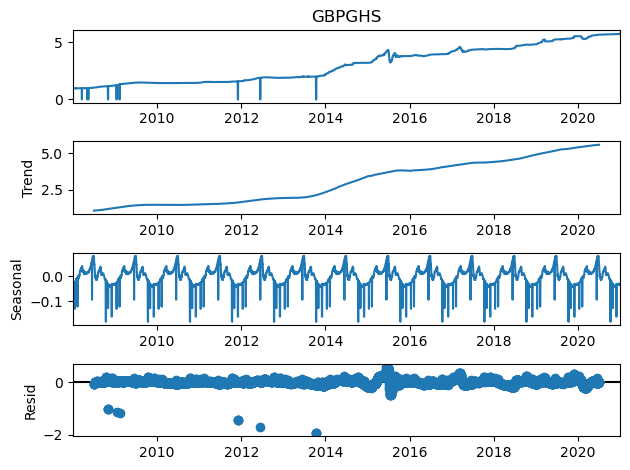

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decompositions = {}
for col in df.columns:
    decomposition = seasonal_decompose(df[col], model='additive', period=365)
    decompositions[col] = decomposition

# Plot the results
for col, decomposition in decompositions.items():
    decomposition.plot()

In [58]:
from statsmodels.tsa.stattools import adfuller

# loop through each column in the dataframe
for col in df.columns:
    # perform ADF test on the column
    result = adfuller(df[col])
    
    # extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]
    
    # print the results
    print('Column:', col)
    print('Test Statistic:', test_statistic)
    print('p-value:', p_value)
    print('Is stationary:', p_value < 0.05)
    print('\n')

Column: USDGHS
Test Statistic: -0.00834331261875678
p-value: 0.9578366370998517
Is stationary: False


Column: GBPGHS
Test Statistic: 0.22464266403560476
p-value: 0.9736103472427099
Is stationary: False




In [5]:
# Split the dataset into training, validation, and testing sets
train_df = df.iloc[:int(len(df)*0.6)]
val_df = df.iloc[int(len(df)*0.6):int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]

In [6]:
# Standardize the data

#buying_mean = train_df['Buying'].mean()
#buying_std = train_df['Buying'].std()
selling_mean = train_df['Selling'].mean()
selling_std = train_df['Selling'].std()
mid_rate_mean = train_df['Mid Rate'].mean()
mid_rate_std = train_df['Mid Rate'].std()


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)


In [8]:
# Define the neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [9]:

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_df[[ 'Selling']].values, 
                    train_df['Mid Rate'].values, 
                    validation_data=(val_df[['Selling']].values, val_df['Mid Rate'].values), 
                    epochs=100, batch_size=32)

Epoch 1/100
61/61 [==============================] - 4s 8ms/step - loss: nan - val_loss: nan
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 8/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 9/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 10/100
61/61 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 11/100
61/61 [==============================] - 0s 3ms/step - l

In [10]:
history.history

{'loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'val_loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

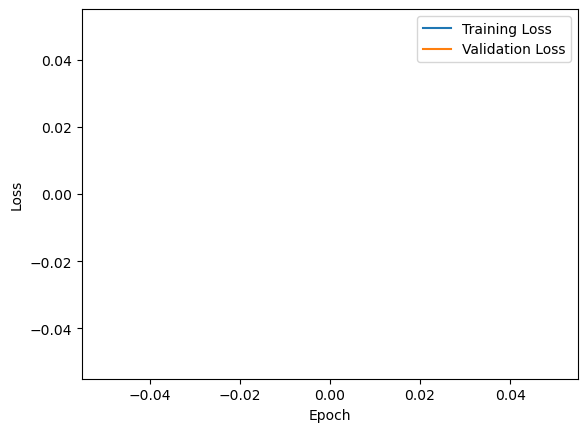

In [46]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:

# Make predictions on the testing data
predictions = model.predict(test_df[[ 'Selling']].values)

21/21 [==============================] - 0s 2ms/step


In [64]:
# Denormalize the predictions and actual values
predictions = predictions * mid_rate_std + mid_rate_mean
actual_values = test_df['Mid Rate'].values

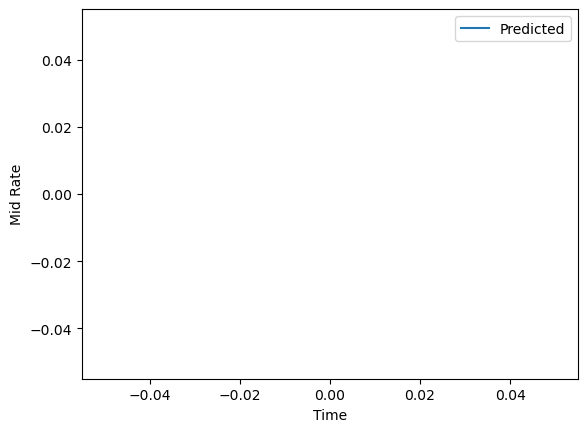

In [81]:
# Plot the predicted and actual values
plt.plot(predictions, label='Predicted')
#plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

In [1]:
# Plot the predicted and actual values
plt.plot(predictions, marker = 'o' ,label='Predicted')
plt.plot(actual_values,marker = '*', label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

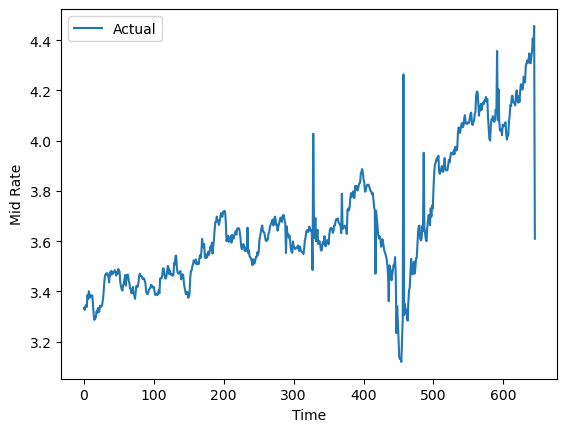

In [84]:
# Plot the predicted and actual values
#plt.plot(predictions, label='Predicted')
plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()